In [161]:
import xarray as xr
import os
import glob
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Dataset
Our dataset consists of ~10 simulations, each is 5-year long, with different perturbed parameters. As a first stage we consider only thetao (3D potential temperature) averaged monthly. We want to create a linear model which can predict the response development over time. We start by preprocessing data: i.e. conservatively coarsegraining data to the 3x3 grid. Later this data will be used to analyse temperature drift for various model runs.

## Read original grid information

In [128]:
param = xr.open_dataset('/home/pp2681/global-runs/data/ocean_static.nc').isel(time=0)

## Initialize horizontal coarsegraining

In [192]:
import xesmf as xe

coords_in = xr.Dataset()
coords_in['lon'] = param.geolon
coords_in['lat'] = param.geolat
coords_in['lon_b'] = param.geolon_c.pad({'yq':(1,0)}, mode='symmetric').pad({'xq':(1,0)}, mode='wrap').drop_vars({'xq','yq'})
coords_in['lat_b'] = param.geolat_c.pad({'yq':(1,0)}, mode='symmetric').pad({'xq':(1,0)}, mode='wrap').drop_vars({'xq','yq'})

# 3-degree grid
coords_out = xe.util.grid_global(3, 3)
regridder_conserv = xe.Regridder(coords_in, coords_out, "conservative_normed", ignore_degenerate=True, periodic=True, unmapped_to_nan=True)

def regrid(array):
    out = regridder_conserv(array)
    lon = out.lon[0,:].values
    lat = out.lat[:,0].values
    return out.drop_vars(['lon', 'lat']).rename({'x':'xh', 'y':'yh'}).assign_coords({'xh': lon, 'yh': lat})

## Apply horizontal and vertical coarsegraining

In [182]:
base_path = '/scratch/pp2681/mom6/OM4_SIS2/'
exp = 'unparameterized'
files = os.path.join(base_path,exp,'output','*ocean_month_z*')
ds = xr.open_mfdataset(files, chunks={'time':1})

thetao = ds.thetao
# Vertical coarsening
param['dz'] = xr.DataArray(np.diff(ds.z_i), dims='z_l')
param['mask_nan'] = xr.where(np.isnan(thetao.isel(time=0)),np.nan,1.)
thetao_coarse_vertical = ((param['dz']* thetao).coarsen({'z_l':3}, boundary='trim').sum() / (param['dz'] * param['mask_nan']).coarsen({'z_l':3}, boundary='trim').sum()).transpose('time','z_l',...)
# Horizontal coarsening
thetao_coarse = regrid(thetao_coarse_vertical)

## Create coarse grid metadata

In [153]:
# Horizontal coarse grid
param_coarse = xr.Dataset()

R = 6.371e+6 
# Zonal distance (dx) varies with latitude
param_coarse['dyt'] = R * np.deg2rad(np.diff(thetao_coarse.xh)[0])
param_coarse['dxt'] = np.cos(np.deg2rad(thetao_coarse.yh)) * param_coarse['dyt']
param_coarse['dz'] = (param['dz']).coarsen({'z_l':3}, boundary='trim').sum()
param_coarse['mask_nan'] = xr.where(np.isnan(thetao_coarse.isel(time=0)),np.nan,1.)

# Compare time series of averaged data

In [154]:
def ave3d(array, param):
    return (array * param.dxt * param.dyt * param.dz * param.mask_nan).sum(['xh','yh','z_l']) / (param.dxt * param.dyt * param.dz * param.mask_nan).sum(['xh','yh','z_l'])

In [196]:
from dask.diagnostics import ProgressBar
with ProgressBar():
    thetao_3d = ave3d(thetao, param).compute()

[########################################] | 100% Completed | 30.39 s


In [197]:
with ProgressBar():
    thetao_coarse_3d = ave3d(thetao_coarse, param_coarse).compute()

[########################################] | 100% Completed | 24.86 s


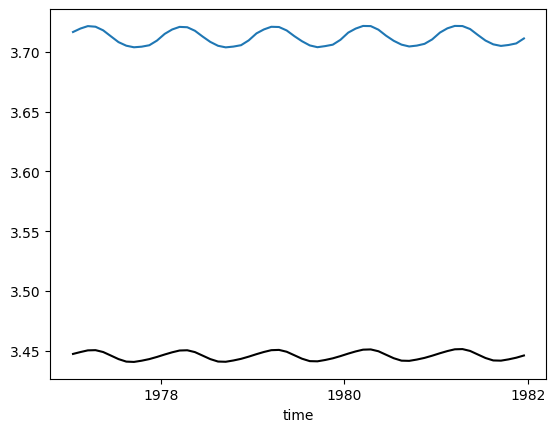

In [198]:
thetao_3d.plot(color='k')
thetao_coarse_3d.plot(color='tab:blue')

## Global integral is different. To be fixed later

In [199]:
(thetao * param.dxt * param.dyt)[0][0].sum().values# / (xr.where(np.isnan(thetao),np.nan,1.) * param.dxt * param.dyt)[0][0].sum().values

array(6.618872e+15, dtype=float32)

In [202]:
(regrid(thetao) * param_coarse.dxt * param_coarse.dyt)[0][0].sum().values# / (xr.where(np.isnan(regrid(thetao)),np.nan,1.) * param_coarse.dxt * param_coarse.dyt)[0][0].sum().values

array(5.65698697e+15)

# Snapshots

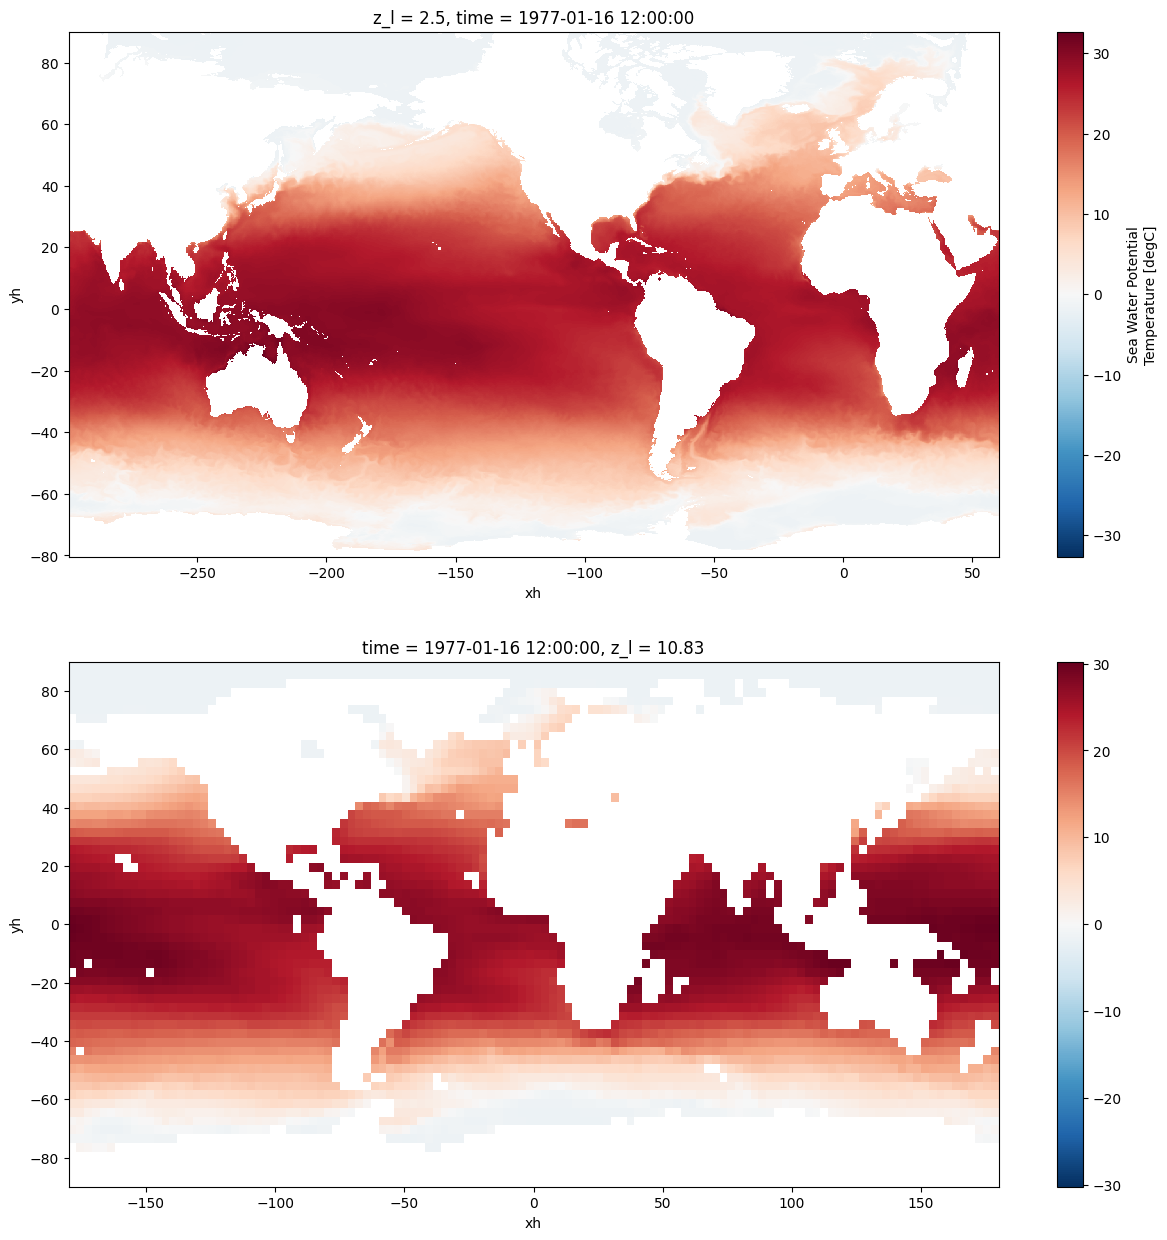

In [205]:
plt.figure(figsize=(15,15))

plt.subplot(2,1,1)
thetao[0][0].plot()

plt.subplot(2,1,2)
thetao_coarse[0][0].plot()

# Coarsegraing all available data

In [209]:
base_path = '/scratch/pp2681/mom6/OM4_SIS2/'
for exp in ['unparameterized', 'unparameterized-0.03', 'unparameterized-0.09',
            'JHAH15', 'GM', 'vert-diff',
            'ZB20-Klower', 'ZB20-Reynolds', 'ZB20-Smooth-1.0', 'ZB20-Smooth-2.5',
            'ANN-greenline', 'ANN-redline', 'ANN-FGR-2', 'ANN-Taper', 'ANN-strain',
            'ANN-1x1', 'ANN-3x3-32-32', 'ANN-3x3-EXP2', 'ANN-5x5-Klower']:
    files = os.path.join(base_path,exp,'output','*ocean_month_z*')
    ds = xr.open_mfdataset(files, chunks={'time':1})
    
    thetao = ds.thetao
    # Vertical coarsening
    param['dz'] = xr.DataArray(np.diff(ds.z_i), dims='z_l')
    param['mask_nan'] = xr.where(np.isnan(thetao.isel(time=0)),np.nan,1.)
    thetao_coarse_vertical = ((param['dz']* thetao).coarsen({'z_l':3}, boundary='trim').sum() / (param['dz'] * param['mask_nan']).coarsen({'z_l':3}, boundary='trim').sum()).transpose('time','z_l',...)
    # Horizontal coarsening
    thetao_coarse = regrid(thetao_coarse_vertical)

    ds_coarse = xr.Dataset()
    ds_coarse['thetao'] = thetao_coarse
    with ProgressBar():
        ds_coarse.to_netcdf(os.path.join('/scratch/pp2681/calibration/OM4-NIF-5-years', f'{exp}.nc'))
    print(f'{exp} is finished')

[########################################] | 100% Completed | 31.08 s
unparameterized is finished
[########################################] | 100% Completed | 31.21 s
unparameterized-0.03 is finished
[########################################] | 100% Completed | 31.99 s
unparameterized-0.09 is finished
[########################################] | 100% Completed | 31.19 s
JHAH15 is finished
[########################################] | 100% Completed | 31.30 s
GM is finished
[########################################] | 100% Completed | 31.91 s
vert-diff is finished
[########################################] | 100% Completed | 32.11 s
ZB20-Klower is finished
[########################################] | 100% Completed | 34.20 s
ZB20-Reynolds is finished
[########################################] | 100% Completed | 32.69 s
ZB20-Smooth-1.0 is finished
[########################################] | 100% Completed | 33.01 s
ZB20-Smooth-2.5 is finished
[########################################] |